https://www.iue.tuwien.ac.at/phd/singulani/dissch3.html


$$
\frac{d^2 u}{dx^2} =f(x),
\\
0<x<1, u(0) = 0, u(1) = 0
\\
f(x) = 1+\delta(x)
$$


In [313]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from sympy.solvers import ode

Analytical solution


In [314]:
x = sp.symbols('x')  # symbol
u = sp.Function('u')  # symbolic function
func = 1 + sp.DiracDelta(x)
eqn = u(x).diff(x).diff(x) - func  # = 0
eqn

-DiracDelta(x) + Derivative(u(x), (x, 2)) - 1

In [315]:
ode.classify_ode(eqn)

('nth_algebraic',
 'nth_linear_euler_eq_nonhomogeneous_undetermined_coefficients',
 'nth_linear_constant_coeff_variation_of_parameters',
 'nth_linear_euler_eq_nonhomogeneous_variation_of_parameters',
 'nth_algebraic_Integral',
 'nth_linear_constant_coeff_variation_of_parameters_Integral',
 'nth_linear_euler_eq_nonhomogeneous_variation_of_parameters_Integral')

In [316]:
sympy_sol = ode.dsolve(eqn, ics={u(0): 0, u(1): 0})
expr = sympy_sol.rhs
f = sp.lambdify(x, expr, 'numpy')
sympy_sol

Eq(u(x), x**2/2 - x/2)

Numerical Solution


In [317]:
xmin = 0
xmax = 1
hx = 0.01

nx = int((xmax - xmin) / hx) + 1
x_array, hx = np.linspace(xmin, xmax, nx, retstep=True)
nx = len(x_array)
nx

101

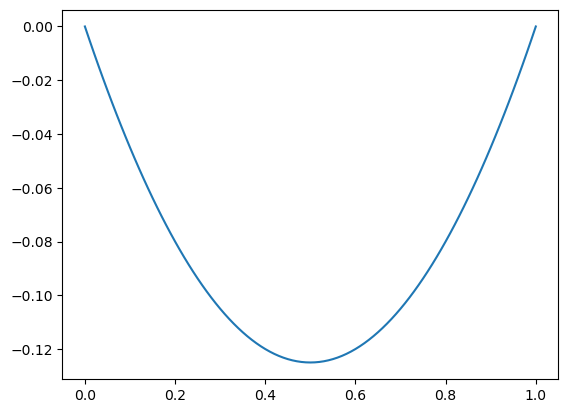

In [318]:
plt.plot(x_array, f(x_array))

In [319]:
def errors(true_values, test_values):
    mse = np.average((true_values - test_values)**2)
    mae = np.average(np.abs(true_values - test_values))
    mx = np.max(np.abs(true_values - test_values))
    print(f"MSE: {mse:.2e}, MAE: {mae:.2e}, MAX: {mx:.2e}")


def tester(x_points, solution_points, test_points, label):
    plt.figure(figsize=(17, 8))
    plt.plot(x_points, solution_points, label='exact sol')
    plt.plot(x_points, test_points, label=label)
    plt.legend()
    plt.ylabel('u')
    plt.xlabel('x')
    plt.grid()

    errors(solution_points, test_points)


sp.var('x_')
f = 1 + sp.DiracDelta(x_)


def solution(x):
    return x**2/2 - x/2


def value_v_k(k):
    def v_k(x):
        return np.piecewise(x, [x_array[k-1] <= x <= x_array[k], x_array[k] < x <= x_array[k+1], x < x_array[k-1] or x > x_array[k+1]],
                            [lambda x: (x - x_array[k-1])/(x_array[k] - x_array[k-1]),
                             lambda x: (x_array[k+1] - x) /
                             (x_array[k+1] - x_array[k]),
                             lambda x: 0])
    return v_k


def matrix_phi():
    phi = []
    for i in range(1, nx-1):
        phi.append([])
        for j in range(1, nx-1):
            if i == j:
                data = 2/hx
            elif (i == j + 1) or (i == j - 1):
                data = -1/hx
            else:
                data = 0
            phi[i-1].append(data)
    phi = np.array(phi)
    return phi


def vector_b():
    b = []
    for i in range(1, nx):
        data = (f.subs({x_: x_array[i]})).evalf() * hx
        b.append(data)
    b = np.array(b)
    return b


def forward(A, B, C, D, n):
    A_ = [-C[0] / B[0]]
    B_ = [D[0] / B[0]]
    for i in range(1, n):
        A_.append(- C[i] / (B[i] + A[i] * A_[i-1]))
        B_.append((D[i] - A[i]*B_[i-1]) / (B[i] + A[i] * A_[i-1]))
    return A_, B_


def backward(A, B, n):
    Y = []
    Y.append(B[n-1])
    for i in range(n - 2, -1, -1):
        Y.append(B[i] + A[i] * Y[n - i - 2])
    return Y[::-1]


def finite_element_method():
    phi = matrix_phi()
    b = vector_b()

    B = phi.diagonal()
    N = len(B)

    A = np.zeros(shape=(N,))
    C = np.zeros(shape=(N,))
    A[1:] = phi.diagonal(-1)
    C[:-1] = phi.diagonal(+1)
    D = ((-1)*b)

    A_, B_ = forward(A, B, C, D, N)
    u = backward(A_, B_, N)
    return u.copy()

In [320]:
u_element = finite_element_method()

In [321]:
basis_ = [value_v_k(k) for k in range(1, nx-1)]
basis_ = np.array(basis_)


def sum(x):
    data = 0
    for i in range(len(basis_)):
        data += u_element[i] * basis_[i](x)
    return data


vectorize = np.vectorize(sum)
numerical_solution1 = vectorize(x_array)
analytical_solution = solution(x_array)

MSE: 3.38e-32, MAE: 1.51e-16, MAX: 3.47e-16


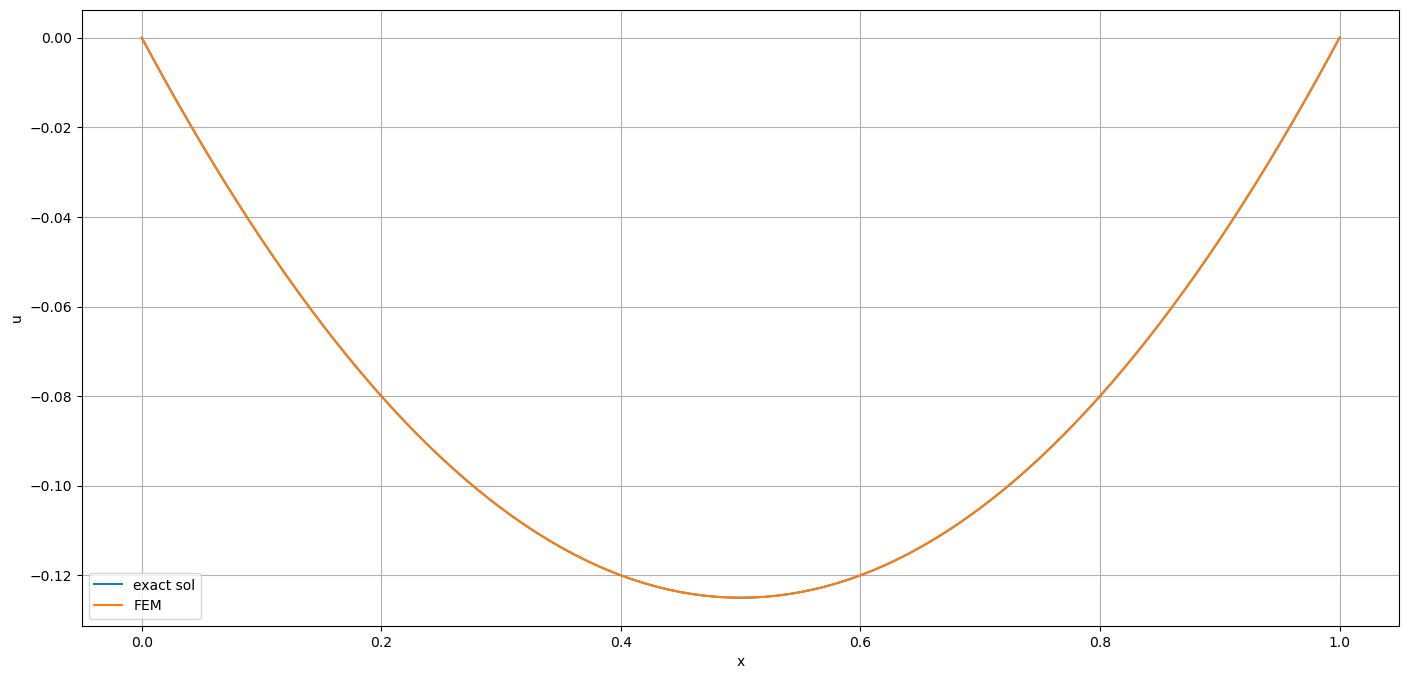

In [322]:
tester(x_array, analytical_solution, numerical_solution1, 'FEM')